# Ice Out Predictor for Rainy Lake

Records of 'ice-out' and 'ice-in' days on selected Minnesota lakes are available from the Minnesota DNR at their web site [Ice Out Dates](http://www.dnr.state.mn.us/ice_out/index.html). The purose of these notes is explore the possibililty of predicting ice-out dates from temperature records.

## Initialization

### Load Python Modules

In [1]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime

# Module to enhance matplotlib plotting
import seaborn
seaborn.set()

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# Styles
from IPython.core.display import HTML
HTML(open("styles/custom.css", "r").read())

## Rainy Lake Ice Out Data Series

Records for ice out dates on Rainy Lake from 1930 to the present day are maintained by the Minnesota DNR, available [here](http://www.dnr.state.mn.us/ice_out/index.html). The data set has been previously downloaded into a file in the data directory. The ice out dates are converted to an integer 'day of year' and stored as a Pandas series object.

1948    127
1949    118
1950    142
1951    129
1952    125
dtype: int32

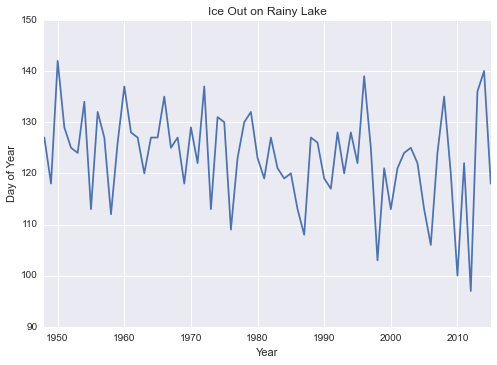

In [2]:
# Read .csv file
RL_ICEOUT = pd.read_csv('./data/IceOut_RL.txt',index_col=0,parse_dates=True,skiprows=1)

# Remove duplicated data
RL_ICEOUT = RL_ICEOUT[RL_ICEOUT[' source']=='MNDNR-SCO']

# Drop unneeded columns
RL_ICEOUT.drop(' source',1,inplace=True)
RL_ICEOUT.drop(' comments',1,inplace=True)

# Slice to 1948 and forward
RL_ICEOUT = RL_ICEOUT['1948':]

# Create 'day of year' ice out events
Y = pd.Series(RL_ICEOUT.index.dayofyear, index=RL_ICEOUT.index.year)

# Display
display(Y.head())
Y.plot()
plt.title('Ice Out on Rainy Lake')
plt.ylabel('Day of Year')
plt.xlabel('Year')



### Distribution of Ice Out Dates

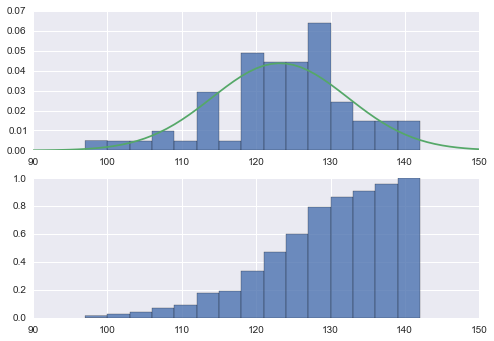

In [3]:
import scipy.stats as stats

param = stats.norm.fit(np.array(Y))

x = np.linspace(90,150,61)
pdf = stats.norm.pdf(x,loc=param[0],scale=param[1])

plt.subplot(2,1,1)
plt.hist(np.array(Y),normed=1,alpha=0.8,bins=15)
plt.hold(True)
plt.plot(x,pdf)
plt.hold(False)

plt.subplot(2,1,2)
Y.hist(cumulative=True,alpha=0.8,bins=15,normed=True)

,TMAX,TMIN
DATE,,
1948-01-01,-8.9,-30.0
1948-01-02,-5.6,-12.2
1948-01-03,-5.0,-10.6
1948-01-04,-4.4,-8.3
1948-01-05,-0.6,-10.0


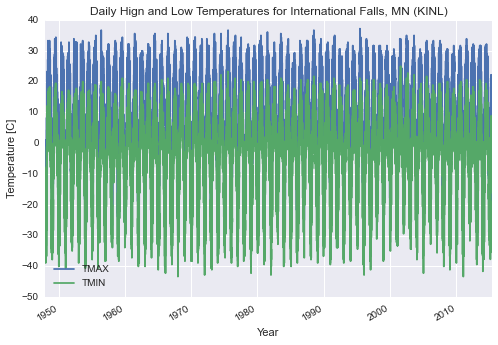

In [4]:
TEMP = pd.read_csv('./data/528052.csv',index_col=2,parse_dates=True);

# Drop unneeded columns
TEMP.drop('STATION',axis=1,inplace=True)
TEMP.drop('STATION_NAME',axis=1,inplace=True)
TEMP.drop('TOBS',axis=1,inplace=True)

# Substitute NaN for missing data
TEMP.ix[TEMP['TMAX']==-9999,'TMAX'] = float('nan')
TEMP.ix[TEMP['TMIN']==-9999,'TMIN'] = float('nan')

# Convert to Celcius
TEMP = TEMP/10.0

# Slice to 1948 and forward
TEMP = TEMP['1948':]

# Display
display(TEMP.head())
TEMP['TMAX'].plot()
plt.hold(True)
TEMP['TMIN'].plot()
plt.hold(False)
plt.legend(loc='best')

plt.title('Daily Hign and Low Temperatures for International Falls, MN (KINL)')
plt.ylabel('Temperature [C]')
plt.xlabel('Year')

## Feature Selection

We seek a correlation between late Winter and early Spring temperature records at International Falls to ice-out dates on Rainy Lake. For this purpose we create additional regressors that might correlate with ice melt. 

$T^{max+}_k$ (respectively $T^{max-}_k$ is the difference by which the daily high temperature $T^{max}_k$ is above (respectively below) the melting point. Since temperature must either be above or below the melting point,

$$T^{max}_k = T^{max+}_k + T^{max-}_k$$ 

where

\begin{align*}
T^{max+}_k & = \max(0,T^{max}_k) \\
T^{max-}_k & = \min(0,T^{max}_k)
\end{align*}

showing the linear dependence among these three regressors. The intuition is that a high mean value of $T^{max+}_k$ in late Winter and early Spring would correlate with an early ice-out date.

Similary, we define $T^{min+}_k$ (respectively $T^{min-}_k$ as 

$$T^{min}_k = T^{min+}_k + T^{min-}_k$$ 

where

\begin{align*}
T^{min+}_k & = \max(0,T^{min}_k) \\
T^{min-}_k & = \min(0,T^{min}_k)
\end{align*}

Here the intuition is that very negative values of $T^{min-}_k$ would correlate with late ice-out dates. Conversely, positive values of $T^{min+}_k$ would suggest periods of ice melt and therefore earlier ice-out.


In [5]:
# Create some additional regressors

fpos = lambda x: max(0,x)
fneg = lambda x: min(0,x)

TEMP['TMAXpos'] = TEMP['TMAX'].apply(fpos)
TEMP['TMAXneg'] = TEMP['TMAX'].apply(fneg)
TEMP['TMINpos'] = TEMP['TMIN'].apply(fpos)
TEMP['TMINneg'] = TEMP['TMIN'].apply(fneg)

display(TEMP.head())
display(TEMP.tail())

,TMAX,TMIN,TMAXpos,TMAXneg,TMINpos,TMINneg
DATE,,,,,,
1948-01-01,-8.9,-30.0,0,-8.9,0,-30.0
1948-01-02,-5.6,-12.2,0,-5.6,0,-12.2
1948-01-03,-5.0,-10.6,0,-5.0,0,-10.6
1948-01-04,-4.4,-8.3,0,-4.4,0,-8.3
1948-01-05,-0.6,-10.0,0,-0.6,0,-10.0


,TMAX,TMIN,TMAXpos,TMAXneg,TMINpos,TMINneg
DATE,,,,,,
2015-04-25,13.3,1.1,13.3,0,1.1,0.0
2015-04-26,15.6,-4.9,15.6,0,0.0,-4.9
2015-04-27,20.0,-4.9,20.0,0,0.0,-4.9
2015-04-28,15.6,-2.1,15.6,0,0.0,-2.1
2015-05-01,21.1,2.2,21.1,0,2.2,0.0


## Empirical Dimensionality Reduction

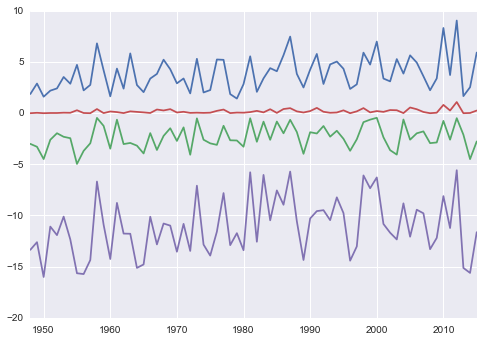

In [6]:
# Given two 'days of year', create a dataframe comprised of the mean value
# of the temperature regression features, indexed by year

def meanTemps(doy1,doy2):
    X = pd.DataFrame(index=Y.index)
    grouped = TEMP.groupby(TEMP.index.year)
    for y, T in grouped:
        T = T[T.index.dayofyear >= doy1]
        T = T[T.index.dayofyear <= doy2]
        for col in T.columns:
            X.ix[y,col] = T[col].mean()
    X.drop('TMAX',axis=1,inplace=True)
    X.drop('TMIN',axis=1,inplace=True)
    X = X.ix[Y.index]
    return X

X = meanTemps(50,105)

for c in X.columns:
    X[c].plot()
    plt.hold(True)
plt.hold(False)

## Elastic Net Regression with Cross-Validation

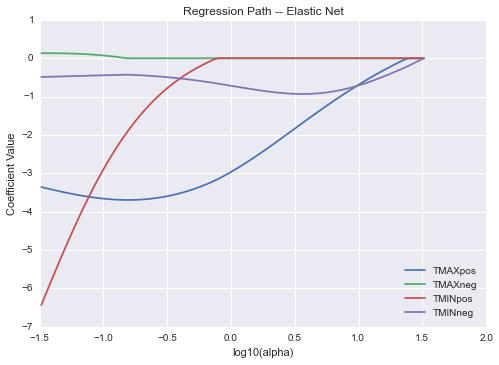

In [7]:
from sklearn.linear_model import enet_path

# Estimate alpha by plotting the elastic net regression as a function of alpha

X = meanTemps(50,105)

alphas, coefs, _ = enet_path(X, np.array(Y), l1_ratio = 0.5)
plt.plot(np.log10(alphas), coefs.T)

plt.legend(X.columns,loc='best')
plt.title('Regression Path -- Elastic Net')
plt.ylabel('Coefficient Value')
plt.xlabel('log10(alpha)')


\begin{align*}
Pred & = \beta_0 + 
\beta_1 \frac{1}{55} \sum_{k=50}^{105} \max(0,T^{max}_k) +
\beta_2 \frac{1}{55} \sum_{k=50}^{105} \max(0,T^{min}_k) + 
\beta_3 \frac{1}{55} \sum_{k=50}^{105} \min(0,T^{min}_k)
\end{align*}


In [8]:
from sklearn.linear_model import ElasticNetCV

# Estimate alpha by plotting the elastic path regression as a function of alpha

X = meanTemps(50,105)

clf = ElasticNetCV(cv = 10, l1_ratio=0.5, n_alphas=1000)
model = clf.fit(X,Y)
print model
print "alpha        = {0:9.5f}".format(clf.alpha_)
print "score        = {0:9.5f}".format(clf.score(X,Y))
for k in range(0,len(X.columns)):
    print "beta_{0:<7s} = {1:9.5f}".format(X.columns[k],clf.coef_[k])
print "intercept    = {0:9.5f}".format(clf.intercept_)


ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=1000, n_jobs=1,
       normalize=False, positive=False, precompute='auto', tol=0.0001,
       verbose=0)
alpha        =   0.03253
score        =   0.72352
beta_TMAXpos =  -3.35665
beta_TMAXneg =   0.13080
beta_TMINpos =  -6.43289
beta_TMINneg =  -0.48781
intercept    = 132.27411


## Look for the Best Calendar Window for Temperatures

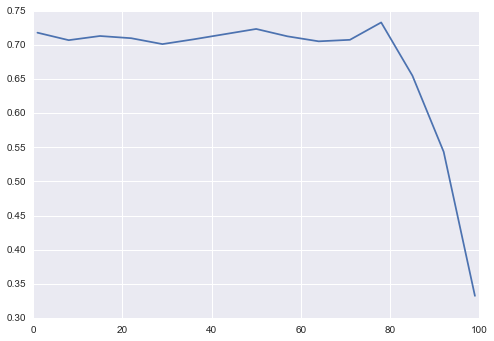

In [9]:
clf = ElasticNetCV(cv = 10, l1_ratio=0.5, n_alphas=1000)

def score(doy):
    X = meanTemps(doy,105)
    clf.fit(X,Y)
    return clf.score(X,Y)

doy = range(1,105,7)
plt.plot(doy,np.array([score(d) for d in doy]))

## Predictor Fit

In [10]:
# Use weeks 12, 13, 14, and 15 for prediction

X = meanTemps(1+11*7, 15*7)

clf = ElasticNetCV(cv = 10, l1_ratio=0.5, n_alphas=1000)
model = clf.fit(X,Y)
print model
print "alpha        = {0:9.5f}".format(clf.alpha_)
print "score        = {0:9.5f}".format(clf.score(X,Y))
for k in range(0,len(X.columns)):
    print "beta_{0:<7s} = {1:9.5f}".format(X.columns[k],clf.coef_[k])
print "intercept    = {0:9.5f}".format(clf.intercept_)

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=1000, n_jobs=1,
       normalize=False, positive=False, precompute='auto', tol=0.0001,
       verbose=0)
alpha        =   0.04018
score        =   0.73306
beta_TMAXpos =  -2.24547
beta_TMAXneg =   1.13415
beta_TMINpos =  -3.71231
beta_TMINneg =  -0.65785
intercept    = 134.46783


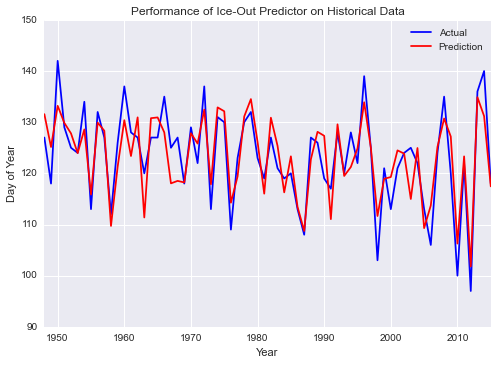

In [11]:
Y.plot(color='b')
P = pd.Series(clf.predict(X),index=X.index);
plt.hold(True)
P.plot(color='r')
plt.hold(False)
plt.legend(['Actual','Prediction'])
plt.title('Performance of Ice-Out Predictor on Historical Data')
plt.ylabel('Day of Year')
plt.xlabel('Year')

fname = './images/IceOut_Prediction.png'

plt.savefig(fname)
!convert $fname -trim $fname

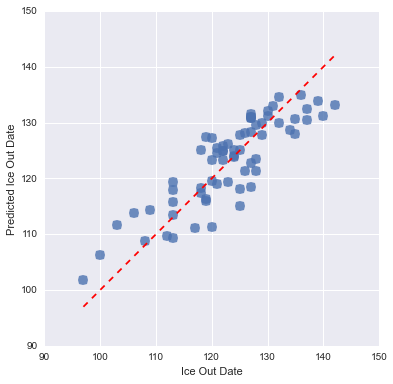

In [12]:
plt.figure(figsize=(6,6))
plt.plot(Y,P,'o',ms=10,alpha=0.8)
plt.hold(True)
x = np.linspace(min([P.min(),Y.min()]), max([P.max(),Y.max()]))
plt.plot(x,x,'r--')
plt.hold(False)

plt.xlabel('Ice Out Date')
plt.ylabel('Predicted Ice Out Date')

In [13]:
(P-Y).std()

4.7472608177953886